# Assignment 1
46110 Basic Aerodynamics  

s163008 Martin Simon  
s134166 Aleksander Andersen

Python Notebook

In [1]:
# Modules
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline

# Task A
Determine $\dfrac{m_1}{c}$ and $\dfrac{m_2}{c}$ for the Joukowski airfoil with relative (to chord) thicknesses of 10%, 20% and 30% and maximum camber 0% and 10%.  
Also try to do this with the linearized approach from the book.

Numerical approach:  
Transformation: $z = \zeta+\dfrac{c^2}{\zeta}$  


Max thickness: $\dfrac{t}{c}\bigg) _{max}$  
Max camber: $\dfrac{h}{c}\bigg) _{max}$  
Just take thickness as be the difference in y-values so $t=y_u-y_l$  
With the camber line: $h = \dfrac{y_y+y_l}{2}$

In [ ]:
## Box not relevant
#R = 1
#N = 2**9 # EVEN number
#x_start, x_end = -5.0, 5.0        # boundaries for x-dir.
#y_start, y_end = -5.0, 5.0        # boundaries for y-dir.
#x_ar = np.linspace(x_start, x_end, N)    #
#y_ar = np.linspace(y_start, y_end, N)
#x, y = np.meshgrid(x_ar,y_ar)               # meshes grid
#
## Complex mesh plane
#z = x+1j*y
#
## Exclusion of points inside circle
#for i in range(N):
#    for j in range(N):
#        if abs(z[i,j])<= (R-5e-3):
#            z[i,j] = complex(float('nan'),float('nan'))
##z = z[None,:,:]

In [3]:
# Some parameters
R = 1.0 # Radius of transformation circle

N = 2**9 # EVEN number. Number of points on airfoil

M1 = 200
M2 = 200
n_tests = int(M1*M2) # Number of tests

R = 1. # Radius of transformation circle 
# Various values for m1/c and m2/c
m1oc = np.linspace(0, 0.4, M1) 
m2oc = np.linspace(0, 0.4, M2)

## Testing the different values

# Empty array to fill in
r_t = np.array([]) # max relative thickness
r_c = np.array([]) # max relative camber
r_m1oc = np.array([]) # m1oc value
r_m2oc = np.array([]) # m2oc value

angle = np.linspace(0, 2*np.pi, N) 

# Actual testing
for i in range(M1):
    for j in range(M2):
        c = R/np.sqrt(m2oc[j]**2+(1+m1oc[i])**2)
        c2 = c**2
        m1 = m1oc[i]*c
        m2 = m2oc[j]*c
        s = -m1 + 1j*m2 # center of circle in zeta
        #J = z+c2/z # Joukowski transformation of all points
        
        # coord. for circle periphery
        z_circle = R*(np.cos(angle)+1j*np.sin(angle)) + s
        
        # coord. for airfoil periphery (J-transform of circle)
        z_airfoil = z_circle+c2/z_circle
        
        chord = np.max(z_airfoil.real) - np.min(z_airfoil.real)
        
        # Find index for leading and trailing edge points
        leftMostPoint = np.argmin(z_airfoil.real)
        rightMostPoint = np.argmax(z_airfoil.real)        
        
        # Splitting into upper and lower part of airfoil
        if rightMostPoint == 0:
            za_upper = z_airfoil[:leftMostPoint]
            za_lower = z_airfoil[leftMostPoint:]
        else:
            _a = z_airfoil[(rightMostPoint-N):]
            za_upper = np.concatenate((_a, z_airfoil[:leftMostPoint]))
            za_lower = z_airfoil[leftMostPoint:rightMostPoint]

        # Interpolation functions for upper and lower airfoil curves
        fu = interpolate.interp1d(za_upper.real,za_upper.imag, kind='linear',bounds_error=False)
        fl = interpolate.interp1d(za_lower.real,za_lower.imag, kind='linear',bounds_error=False)
        
        # Limit values for interpolation.
        # Edge values are removed to avoid any errors
        lim1 = np.min( z_airfoil.real )*0.95
        lim2 = np.max( z_airfoil.real )*0.95
        # Evaluation points
        span = np.linspace(lim1,lim2,400)
        
        
        # Finding max relative thickness
        max_t = np.max( (fu(span) - fl(span))/chord )
        # Max relative camber
        max_camber = np.max( (fu(span)+fl(span))/2 )
        
        # Save result
        r_t = np.append(r_t, max_t)
        r_c = np.append(r_c, max_camber)
        r_m1oc = np.append(r_m1oc, m1oc[i])
        r_m2oc = np.append(r_m2oc, m2oc[j])

In [4]:
# Save data to files
np.savetxt('maxRelThickness.txt',r_t)
np.savetxt('maxRelCamber.txt',r_c)
np.savetxt('m1oc.txt',r_m1oc)
np.savetxt('m2oc.txt',r_m2oc)

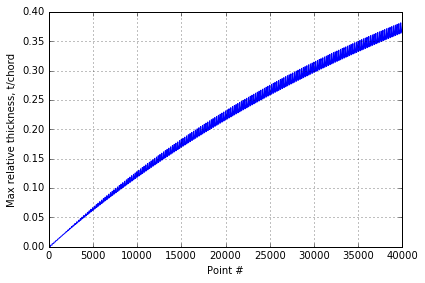

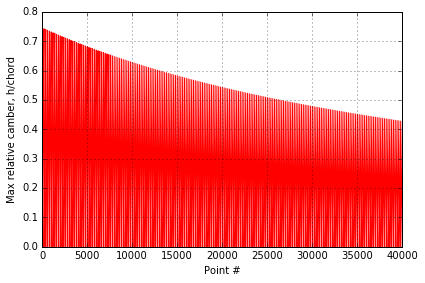

In [5]:
plt.figure()
plt.plot(r_t,'-b')
plt.xlabel('Point #')
plt.ylabel('Max relative thickness, t/chord')
plt.grid()
plt.tight_layout()
plt.savefig('01_J_rt.pdf')

plt.figure()
plt.plot(r_c,'-r')
plt.xlabel('Point #')
plt.ylabel('Max relative camber, h/chord')
plt.grid()
plt.tight_layout()
plt.savefig('02_J_rh.pdf')

### Results for part A

In [9]:
# Relative camber 0%
# Relative thickness 10%
camberVal = 0
thickVal = 0.1
for i in range(r_t.size):
    if r_c[i] < 0.00001:
        if thickVal+0.001 > r_t[i] > thickVal-0.001:
            print(i)
            print('t:',r_t[i])
            print('h:',r_c[i])
            print('(m1oc, m2oc) = ({0:.4f}, {1:.4f})'.format(r_m1oc[i], r_m2oc[i]))

8400
t: 0.100975414471
h: 1.2490009027e-16
(m1oc, m2oc) = (0.0844, 0.0000)


In [13]:
# Relative camber 0%
# Relative thickness 20%
camberVal = 0
thickVal = 0.2
for i in range(r_t.size):
    if r_c[i] < 0.0001:
        if thickVal+0.001 > r_t[i] > thickVal-0.001:
            print(i)
            print('t:',r_t[i])
            print('h:',r_c[i])
            print('(m1oc, m2oc) = ({0:.4f}, {1:.4f})'.format(r_m1oc[i], r_m2oc[i]))

18200
t: 0.19966854897
h: 1.2490009027e-16
(m1oc, m2oc) = (0.1829, 0.0000)


In [14]:
# Relative camber 0%
# Relative thickness 30%
camberVal = 0
thickVal = 0.3
for i in range(r_t.size):
    if r_c[i] < 0.0001:
        if thickVal+0.001 > r_t[i] > thickVal-0.001:
            print(i)
            print('t:',r_t[i])
            print('h:',r_c[i])
            print('(m1oc, m2oc) = ({0:.4f}, {1:.4f})'.format(r_m1oc[i], r_m2oc[i]))

30400
t: 0.299846278332
h: 1.11022302463e-16
(m1oc, m2oc) = (0.3055, 0.0000)


In [20]:
# Relative camber 10%
# Relative thickness 10%
camberVal = 0.1
thickVal = 0.1
for i in range(r_t.size):
    if 0.09 < r_c[i] <= 0.11:
        if thickVal+0.001 > r_t[i] > thickVal-0.001:
            print(i)
            print('t:',r_t[i])
            print('h:',r_c[i])
            print('(m1oc, m2oc) = ({0:.4f}, {1:.4f})'.format(r_m1oc[i], r_m2oc[i]))

8231
t: 0.0990037374396
h: 0.10680871039
(m1oc, m2oc) = (0.0824, 0.0623)


In [27]:
# Relative camber 10%
# Relative thickness 20%
camberVal = 0.1
thickVal = 0.2
for i in range(r_t.size):
    if camberVal-0.0001 < r_c[i] <= camberVal+0.0001:
        if thickVal+0.001 > r_t[i] > thickVal-0.001:
            print(i)
            print('t:',r_t[i])
            print('h:',r_c[i])
            print('(m1oc, m2oc) = ({0:.4f}, {1:.4f})'.format(r_m1oc[i], r_m2oc[i]))

18234
t: 0.200143632843
h: 0.099904238356
(m1oc, m2oc) = (0.1829, 0.0683)


In [31]:
# Relative camber 10%
# Relative thickness 30%
camberVal = 0.1
thickVal = 0.3
for i in range(r_t.size):
    if camberVal-0.001 < r_c[i] < camberVal+0.001:
        if thickVal+0.001 > r_t[i] > thickVal-0.001:
            print(i)
            print('t:',r_t[i])
            print('h:',r_c[i])
            print('(m1oc, m2oc) = ({0:.4f}, {1:.4f})'.format(r_m1oc[i], r_m2oc[i]))

30240
t: 0.299132189699
h: 0.0998706788362
(m1oc, m2oc) = (0.3035, 0.0804)
30440
t: 0.300604380861
h: 0.0996214662651
(m1oc, m2oc) = (0.3055, 0.0804)


# Task B
Karman-Trefftz transformation.  
$\dfrac{z-nc}{z+nc} = \left(\dfrac{\zeta-c}{\zeta+c}\right)^n$  

$z=n{\dfrac  {\left(1+{\dfrac  {1}{\zeta }}\right)^{n}+\left(1-{\dfrac  {1}{\zeta }}\right)^{n}}{\left(1+{\dfrac  {1}{\zeta }}\right)^{n}-\left(1-{\dfrac{1}{\zeta }}\right)^{n}}}$ --- Wrong ??

$z = \left(\dfrac{\zeta-c}{\zeta+c}\right)^n z + \left(\dfrac{\zeta-c}{\zeta+c}\right)^n nc$  
$z\left[1-\left(\dfrac{\zeta-c}{\zeta+c}\right)^n\right] = \left(\dfrac{\zeta-c}{\zeta+c}\right)^n nc$  
$z = nc \left(\dfrac{\zeta-c}{\zeta+c}\right)^n \left[1-\left(\dfrac{\zeta-c}{\zeta+c}\right)^n\right]^{-1} = \dfrac{nc \, (\zeta-c)^n}{(\zeta+c)^n - (\zeta-c)^n}$

B.1  
Karman-Trefftz transformation for trailing edge angle $\beta$ = 18°.  
$\beta=2\pi-n\pi \leftrightarrow n=2-\beta/\pi$

In [ ]:
# Parameters
alphad = 0 # angle of attack
betad = 18 # trailing edge angle

R = 1. # Radius of transformation circle

# Calculations on parameters
theta_str = str(alphad)+'°'
alpha = alphad*np.pi/180
beta = betad*np.pi/180
#c = R/np.sqrt(m2oc**2+(1+m1oc)**2)
c2 = c**2
#chord = 4*c
#m1 = m1oc*c
#m2 = m2oc*c
#s = -m1 + 1j*m2

# Karman Trefftz parameter for 18° TEA
n_kt = 2-beta/np.pi
print('Kármán-Trefftz parameter for 18° trailing edge angle \nn= {:.2f}'.format(n_kt))

In [ ]:
N = 2**9 # EVEN number
x_start, x_end = -5.0, 5.0        # boundaries for x-dir.
y_start, y_end = -5.0, 5.0        # boundaries for y-dir.
x_ar = np.linspace(x_start, x_end, N)    #
y_ar = np.linspace(y_start, y_end, N)
x, y = np.meshgrid(x_ar,y_ar)               # meshes grid

# Complex mesh plane
z = x+1j*y

# Exclusion of points inside circle
for i in range(N):
    for j in range(N):
        if abs(z[i,j])<= (R-5e-3):
            z[i,j] = complex(float('nan'),float('nan'))
#z = z[None,:,:]

In [ ]:
# Number of points to test for m1oc, m2oc
M1 = 40
M2 = 40
n_tests = int(M1*M2) # Number of tests

# Various values for m1/c and m2/c
m1oc = np.linspace(0, 0.32, M1) 
m2oc = np.linspace(0, 0.32, M2)

## Testing the different values

# Empty array to fill in
r_t = np.array([]) # max relative thickness
r_c = np.array([]) # max relative camber
r_m1oc = np.array([]) # m1oc value
r_m2oc = np.array([]) # m2oc value

angle = np.linspace(0, 2*np.pi, N) 

#fig1,ax1 = plt.subplots()
#fig2,ax2 = plt.subplots()

# Actual testing
for i in range(M1):
    for j in range(M2):
        c = R/np.sqrt(m2oc[j]**2+(1+m1oc[i])**2)
        c2 = c**2
        m1 = m1oc[i]*c
        m2 = m2oc[j]*c
        s = -m1 + 1j*m2 # center of circle in zeta
        
        # Coord.: Circle periphery
        z_circle = R*(np.cos(angle)+1j*np.sin(angle)) + s
        
        # Coord.: Airfoil periphery (KT-transform of circle)
        #z_airfoil = ((1+1/z_circle)**n_kt + (1-1/z_circle)**n_kt) / (((1+1/z_circle)**n_kt - (1-1/z_circle)**n_kt) )
        z_airfoil = (z_circle-c)**n_kt * n_kt*c/( (z_circle+c)**n_kt - (z_circle-c)**n_kt )
        
        # Chord length as the distance along the real axis.
        chord = np.max(z_airfoil.real) - np.min(z_airfoil.real)
        
        leftMostPoint = np.argmin(z_airfoil.real)
        rightMostPoint = np.argmax(z_airfoil.real)        
        
        if rightMostPoint == 0:
            za_upper = z_airfoil[:leftMostPoint]
            za_lower = z_airfoil[leftMostPoint:]
        else:
            _a = z_airfoil[(rightMostPoint-N):]
            za_upper = np.concatenate((_a, z_airfoil[:leftMostPoint]))
            za_lower = z_airfoil[leftMostPoint:rightMostPoint]
        

        
        # Upper part of airfoil (from right to left)
        #za_upper = z_airfoil[(N-leftMostPoint):]
        #za_upper = za_upper[::-1] # Reversing array order
        
        # Lower part of airfoil (left to right)
        #za_lower = z_airfoil[(leftMostPoint+1):]

        # Interpolation functions for upper and lower airfoil curve
        fu = interpolate.interp1d(za_upper.real,za_upper.imag, kind='linear',bounds_error=False)
        fl = interpolate.interp1d(za_lower.real,za_lower.imag, kind='linear',bounds_error=False)
        
        # Limit values for interpolation.
        # Edge values are removed to avoid any errors
        lim1 = np.min( z_airfoil.real )*0.95
        lim2 = np.max( z_airfoil.real )*0.95
        # Evaluation points
        span = np.linspace(lim1,lim2,200)
        
        
        # Finding max relative thickness
        max_t = np.max( (fu(span) - fl(span))/chord )
        max_camber = np.max( (fu(span)+fl(span))/2 )
        
        # Save result
        r_t = np.append(r_t, max_t)
        r_c = np.append(r_c, max_camber)
        r_m1oc = np.append(r_m1oc, m1oc[i])
        r_m2oc = np.append(r_m2oc, m2oc[j])
        
        # Plotting
        
        #if i%2==0 and j%2==0:
            #ax1.plot(z_circle.real, z_circle.imag,'-')
            #ax1.set_aspect('equal')
            #ax2.plot(z_airfoil.real, z_airfoil.imag,'-',label=[i,j])
            #ax2.set_aspect('equal')
            
            # X-Y limits for zooming in on trailing edge
            #ax2.set_xlim(-0.01,0.01)
            #ax2.set_ylim(-0.01,0.01)

In [ ]:
plt.plot(z_circle.real, z_circle.imag,'.')

In [ ]:
plt.plot(z_airfoil.real, z_airfoil.imag,'o')

In [ ]:

# Print and plot if within tolerance.
ind = np.argmax((fu(span) - fl(span))/chord) # index in span
print('trel: {0:.5f} - m/c= ({1:.3f}, {2:.3f})'.format(max_trel, m1oc[i], m2oc[j]))
plt.plot(span,fu(span),'.-b')
plt.plot(span,fl(span),'.-r')
plt.plot(span[ind],fu(span[ind]),'ro',ms=5)
plt.plot(span[ind],fl(span[ind]),'bo',ms=5)

In [ ]:
g = np.linspace(0,10,11,endpoint=True)
print(g)

In [ ]:
g[::1]

In [ ]:
np.hstack(([5],[2,3]))

In [ ]:
z_airfoil

In [ ]:
z_airfoil.real

In [ ]:
np.argmin(z_airfoil.real)

In [ ]:
np.argmax(z_airfoil.real)

In [ ]:
angle

In [ ]:
g[-5:]

In [ ]:
g.size

In [ ]:
g[4:]

In [ ]:
g[(9-11+2):]

In [ ]:
g[5]

In [ ]:
h = np.array([11,11,11])

In [ ]:
h

In [ ]:
g

In [ ]:
np.concatenate((g,h))

In [ ]:
_a